#### imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import time 
import datetime

#from tensorflow.image import resize

from matplotlib import pyplot as plt
from IPython import display

In [6]:
#Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the dataset

In [4]:
path_to_dataset = pathlib.Path('dataset')
PATH = path_to_dataset

In [5]:
sample_image = tf.io.read_file(str(PATH/'small_train/0.jpg'))
sample_image = tf.image.decode_jpeg(sample_image)

In [298]:
from matplotlib.colors import hsv_to_rgb
def plot_rgb_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def plot_hsv_image(image):
    image = tf.cast(image, tf.float32)
    rgb = hsv_to_rgb(image)
    print(rgb[0])
    #plt.imshow(rgb, cmap='rgb')
    #plt.imshow(tf.image.rgb_to_hsv(image), cmap='hsv')
    plt.axis('off')
    plt.show()

def plot_lab_image(image):   
    plt.imshow(tf.io.image.rgb_to_lab(image), cmap='lab')
    plt.axis('off')
    plt.show()


In [267]:
# plot the sample image in both RGB and grayscale

def plot_input_and_ground_truth(Ground_truth, Input_image=None):
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    
    if Input_image is  None:
        plt.imshow(tf.image.rgb_to_grayscale(Ground_truth), cmap='gray')
    else:
        plt.imshow(Input_image /255, cmap='gray')
    plt.title('Grayscale')
    plt.subplot(1,2,2)
    
    plt.imshow(Ground_truth / 255)
    plt.title('HSV')
    plt.show()

In [279]:
def load(image_path):
    image = tf.io.read_file(image_path)
    #plt.imshow(image)
    image = tf.image.decode_jpeg(image)
    #print(image[0][0])
    image = tf.cast(image, tf.bfloat16)
    #print(image[0][0])

    image_grayscale = tf.image.rgb_to_yuv(image)
    print(image_grayscale[0])
    image = tf.image.rgb_to_hsv(image)
    #print(image[0][0])
    print(image_grayscale[0][0])

    return image_grayscale, image

In [299]:


image = tf.io.read_file(str(PATH/'small_train/0.jpg'))
image = tf.image.decode_jpeg(image, dct_method='INTEGER_ACCURATE',)

plot_lab_image(image)

#image_hsv = tfio.experimental.color.lab_to_rgb(image)

#image = tf.cast(image, tf.int64)
#image_f64 = tf.cast(image, tf.float64)



#print(image_f64[0][0] == image[0][0])
#image_grayscale = tf.image.rgb_to_grayscale(image)
#plt.imshow(image_grayscale, cmap='gray')
#image_hsv = tf.image.rgb_to_hsv(image)
#plt.imshow(image_hsv)



AttributeError: 'function' object has no attribute 'image'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[ 2.33987000e+02 -1.03279362e+01  5.27511358e+00]
 [ 1.79204010e+02 -9.45050049e+00  3.33016825e+00]
 [ 6.68280029e+01 -5.82068825e+00  3.66002679e+00]
 [ 8.92299957e+01 -5.52640533e+00  2.43007469e+00]
 [ 1.15115997e+02 -5.96241570e+00  2.53008270e+00]
 [ 1.11116005e+02 -5.96241570e+00  2.53008413e+00]
 [ 1.61186996e+02 -6.98158073e+00  3.34508252e+00]
 [ 2.48828003e+02 -5.82068825e+00  3.66002917e+00]
 [ 2.54201996e+02 -3.05207062e+00  7.00075984e-01]
 [ 2.54201996e+02 -3.05207062e+00  7.00075984e-01]
 [ 2.52919998e+02 -5.37385178e+00  7.01875985e-02]
 [ 2.50866013e+02 -6.82361031e+00 -7.59720981e-01]
 [ 2.53175995e+02 -6.97616386e+00  1.60016835e+00]
 [ 2.45649002e+02 -7.70104599e+00  1.18521631e+00]
 [ 2.50871002e+02 -4.36552048e+00  2.74502277e+00]
 [ 2.52098984e+02 -3.49349403e+00  2.54500198e+00]
 [ 2.50871002e+02 -4.36552048e+00  2.74502277e+00]
 [ 2.36632019e+02 -5.23212814e+00  1.20013499e+00]
 [ 1.74959015e+02 -7.85359764e+00  3.54510379e+00]
 [ 2.22959015e+02 -7

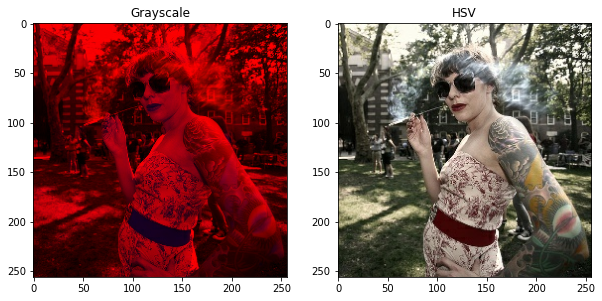

In [265]:
inp, re = load(str(PATH/'small_train/0.jpg'))

print("reee", re[0][0])
re = tf.image.hsv_to_rgb(re)
print("reeeeee", re[0][0])
plot_input_and_ground_truth(re , inp)


In [71]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_SIZE = [256,256]
IMG_HEIGHT = IMG_SIZE[0]
IMG_WIDTH = IMG_SIZE[1]
OUTPUT_CHANNELS = 3
LAMBDA = 100

#### Augmentation

In [19]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image


def random_crop(input_image, real_image):
  # Scale input_image from 286x286x1 to 286x286x3
  input_image = tf.concat([input_image, input_image, input_image], axis=2)
  print(input_image.shape)
  
  stacked_image = tf.stack([input_image, real_image], axis=0)
  print(stacked_image.shape)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  print(cropped_image, cropped_image[1])
  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


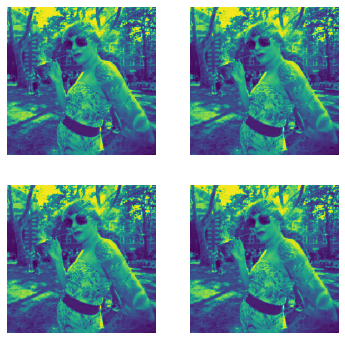

In [20]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  #input_image, real_image = random_crop(input_image, real_image)

  #if tf.random.uniform(()) > 0.5:
  #  # Random mirroring
  #  input_image = tf.image.flip_left_right(input_image)
  #  real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()


In [21]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  #input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [22]:
train_dataset = tf.data.Dataset.list_files(str(PATH/'small_train/*.jpg'))
train_dataset = train_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Tensor("truediv:0", shape=(None, None, None), dtype=float32)


In [23]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'small_test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

def dataset_fn(ds):
  return ds.filter(lambda x: x < 5)

Tensor("truediv:0", shape=(None, None, None), dtype=float32)


### Defining the generator

In [24]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs
  
  

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
        

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

tf.Tensor(
[[[0.9411765  0.92156863 0.8352941 ]
  [0.7176471  0.70980394 0.627451  ]
  [0.2784314  0.2627451  0.21568628]
  ...
  [0.10980392 0.12156863 0.08627451]
  [0.11372549 0.13725491 0.09019608]
  [0.23921569 0.2627451  0.20784314]]

 [[0.9411765  0.92156863 0.84313726]
  [0.6784314  0.6666667  0.5921569 ]
  [0.27450982 0.26666668 0.21568628]
  ...
  [0.15686275 0.16862746 0.14117648]
  [0.18431373 0.20784314 0.16078432]
  [0.19215687 0.21568628 0.16078432]]

 [[0.8392157  0.827451   0.7529412 ]
  [0.9019608  0.8901961  0.8235294 ]
  [0.49411765 0.4862745  0.4392157 ]
  ...
  [0.27058825 0.28235295 0.25490198]
  [0.10588235 0.12941177 0.09019608]
  [0.07450981 0.09803922 0.05098039]]

 ...

 [[0.16078432 0.16470589 0.14117648]
  [0.20392157 0.20784314 0.18431373]
  [0.16078432 0.16470589 0.13333334]
  ...
  [0.02745098 0.03529412 0.01568628]
  [0.01176471 0.01960784 0.        ]
  [0.01568628 0.02352941 0.00392157]]

 [[0.14509805 0.14901961 0.1254902 ]
  [0.21960784 0.22352941 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


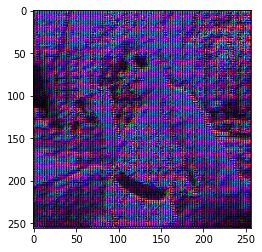

In [26]:
inp, re = load(str(PATH/'small_train/0.jpg'))

gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Defining discriminator

In [29]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

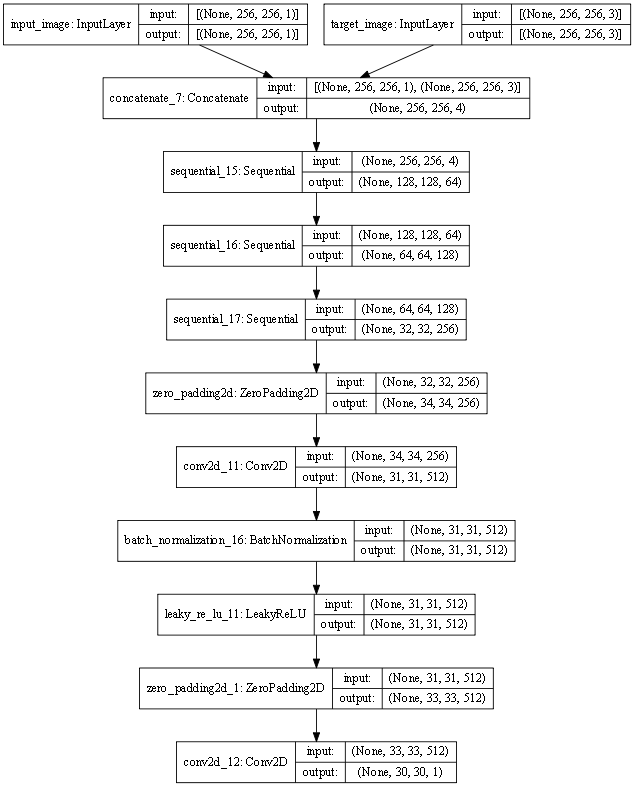

In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

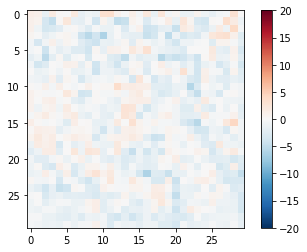

In [31]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Define optimizer and a checkpoint saver

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Generate images

In [34]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    if i == 0:
      plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    else:
      plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

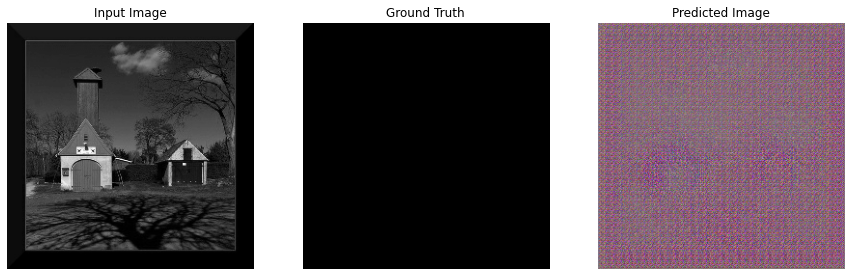

In [35]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Training

In [36]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [38]:
def fit(train_ds, test_ds, steps, load_checkpoint=False):

  if load_checkpoint:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [39]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 21456), started 1 day, 19:35:41 ago. (Use '!kill 21456' to kill it.)

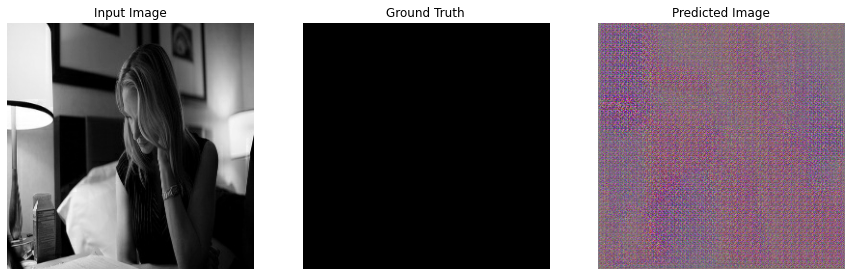

Step: 0k


KeyboardInterrupt: 

In [40]:
fit(train_dataset, test_dataset, steps=100000)

In [ ]:
#fit(train_dataset, test_dataset, steps=10000, load_checkpoint=True)